C:\Users\USER\AppData\Local\Temp\ipykernel_60388\1800746918.py:39: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


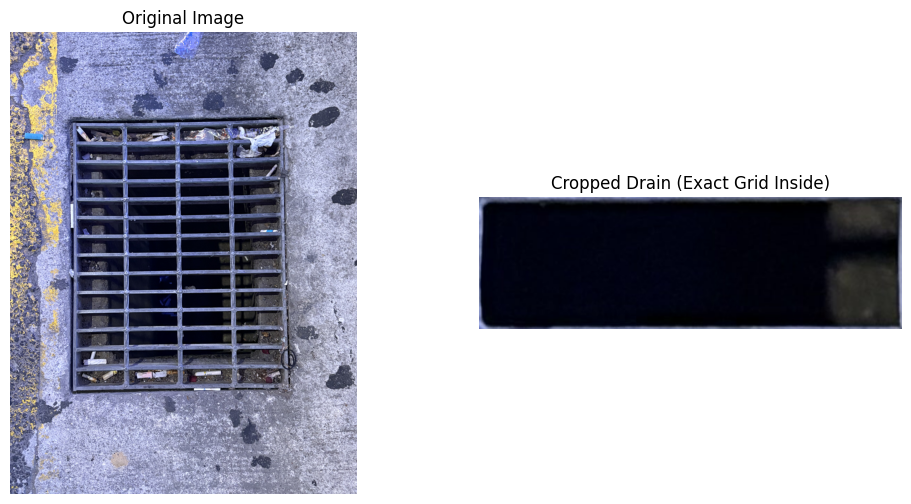

In [12]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def crop_drain_inside_outline(image_path):
    img_color = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

    # ---- Gabor filter로 격자 강조 ----
    def apply_gabor(img, theta):
        kernel = cv2.getGaborKernel((31, 31), 4.0, theta, 10.0, 0.5, 0)
        return cv2.filter2D(img, cv2.CV_8UC3, kernel)

    gabor_0 = apply_gabor(img_gray, 0)
    gabor_90 = apply_gabor(img_gray, np.pi / 2)
    gabor = cv2.addWeighted(gabor_0, 0.5, gabor_90, 0.5, 0)

    # ---- Canny edge + 윤곽선 ----
    edges = cv2.Canny(gabor, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # ---- 가장 큰 윤곽선 찾기 (격자 전체 테두리로 추정) ----
    max_area = 0
    best_cnt = None
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > max_area:
            max_area = area
            best_cnt = cnt

    if best_cnt is None:
        print("❌ 윤곽선을 찾지 못함")
        return None, None

    # ---- 외곽 윤곽선 -> 회전된 박스 좌표로 변환 ----
    rect = cv2.minAreaRect(best_cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # ---- 좌표 정렬 (좌상-우상-우하-좌하 순서) ----
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        diff = np.diff(pts, axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    ordered = order_points(box)

    # ---- 투시 변환으로 내부만 정밀 크롭 ----
    (tl, tr, br, bl) = ordered
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)

    maxWidth = int(max(widthA, widthB))
    maxHeight = int(max(heightA, heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(ordered, dst)
    warped = cv2.warpPerspective(img_color, M, (maxWidth, maxHeight))

    # 결과 반환 (PIL 이미지)
    original_pil = Image.fromarray(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    cropped_pil = Image.fromarray(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    return original_pil, cropped_pil


# 적용할 이미지 경로
img_path = "C:/Users/USER/Desktop/medium_change/IMG_9002.jpg"

# 크롭 실행
orig, cropped = crop_drain_inside_outline(img_path)

# 시각화
if cropped:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(orig)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cropped)
    plt.title("Cropped Drain (Exact Grid Inside)")
    plt.axis("off")
    plt.show()
else:
    print("⚠️ 크롭 실패")
